In [1]:
import glob
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

In [2]:
# algorithms = ['gemm', 'igemm', 'ipgemm', 'fft', 'fftt', 'wino']
algorithms = [0, 1, 2]
features = ['in_channels', 'out_channels', 'kernel_size', 'stride', 'groups', 'hw']

configs = pd.read_csv('./search_space/regnet_convs_unique.csv')
train_cfg_strs = []
test_cfg_strs = []
for i, row in configs.iterrows():
    cfg_str = '_'.join([str(int(row[k])) for k in features])
    if i < 4000:
        train_cfg_strs.append(cfg_str)
    else:
        test_cfg_strs.append(cfg_str)

In [3]:
def read_log(mode, algo):
    # df = pd.read_csv(sorted(glob.glob(f'./logs/{mode}/{algo}-*.csv'))[-1])
    if mode == 'energy':
        df = pd.read_csv(f'./logs/energy/{algo}-20230302.csv')
    elif mode == 'latency':
        df = pd.read_csv(f'./logs/latency/{algo}-20230303.csv')
    df['algo'] = algo
    df['params'] = df['out_channels'] * (np.square(df['kernel_size']) * df['in_channels'] / df['groups'] + 1)
    df['flops'] = np.square(df['hw'] // df['stride'])
    return df

energy_df = pd.concat([read_log('energy', algo) for algo in algorithms], ignore_index=True)
energy_df['test'] = [
    '_'.join([str(int(row[k])) for k in features]) in test_cfg_strs
    for i, row in energy_df.iterrows()
]
latency_df = pd.concat([read_log('latency', algo) for algo in algorithms], ignore_index=True)

print(f'Energy entries: {len(energy_df)} / Latency entries: {len(latency_df)} ')
# features = features + ['params', 'flops']

energy_df['power'] = energy_df['energy'] / energy_df['latency']
energy_df

Energy entries: 19292 / Latency entries: 118718 


,in_channels,out_channels,kernel_size,stride,groups,hw,gpu_id,algo,profile_energy,num_warmups,num_iters,latency,energy,power,params,flops,test
0,1680,1680,3,1,10,7,1,0,1,200,9894,0.000924,0.053571,57.975172,2541840.0,49,False
1,3000,3000,3,2,25,14,1,0,1,200,9898,0.001154,0.118329,102.516761,3243000.0,49,False
2,208,52,1,1,1,14,1,0,1,200,58890,0.000125,0.006172,49.261049,10868.0,196,False
3,792,792,3,2,11,7,1,0,1,200,22650,0.000206,0.010893,52.828974,514008.0,9,False
4,448,448,3,2,4,56,1,0,1,200,5547,0.001785,0.110875,62.101121,452032.0,784,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19287,4,16,1,1,1,112,4,4,1,200,19891,0.000428,0.029720,69.458025,80.0,12544,True
19288,420,1680,1,1,1,14,4,4,1,200,2674,0.003698,0.487133,131.719392,707280.0,196,True
19289,2088,2088,3,1,9,14,4,4,1,200,2994,0.003266,0.426461,130.592154,4361832.0,196,True
19290,88,22,1,1,1,28,4,4,1,200,20838,0.000216,0.014769,68.349140,1958.0,784,True


In [4]:
def calc_rmse(y, pred):
    return np.sqrt(np.mean(np.square(y - pred)))

def calc_err(y, pred):
    return np.abs(y - pred) / y

def calc_acc(err, r):
    return sum(err <= r) / len(err) * 100

def evaluate(model, X, y, exp2=True):
    pred = model.predict(X)
    if exp2:
        y = np.exp2(y)
        pred = np.exp2(pred)
    err = calc_err(y, pred)
    results = [calc_acc(err, 0.05), calc_acc(err, 0.1), calc_acc(err, 0.15), calc_rmse(y, pred)]
    print("5%% : %2.2f%% | 10%% : %2.2f%% | 15%% : %2.2f%% | RMSE : %1.5f" % tuple(results))
    return results

In [5]:
def calc_grid_size(df, channel_thres, hw_thres, precomp):
    channel_scale = np.ceil(df['out_channels'] / channel_thres)
    if precomp:
        hw = df['hw'] - df['kernel_size'] + 1
    else:
        hw = df['hw']
    hw_scale = np.ceil(np.square(hw / df['stride']) / hw_thres)
    return (channel_scale * hw_scale).astype(np.int32)

def add_grid_size(df):
    df['grid_size_0'] = calc_grid_size(df, 32, 32, False)
    df['grid_size_1'] = calc_grid_size(df, 128, 64, False)
    # df['grid_size_2'] = calc_grid_size(df, 256, 64, False)
    # df['grid_size_3'] = calc_grid_size(df, 32, 32, True)
    # df['grid_size_4'] = calc_grid_size(df, 128, 64, True)

# grid_size_features = ['grid_size_0', 'grid_size_1', 'grid_size_2', 'grid_size_3', 'grid_size_4']
grid_size_features = ['grid_size_0', 'grid_size_1']
add_grid_size(energy_df)
add_grid_size(latency_df)
energy_df

,in_channels,out_channels,kernel_size,stride,groups,hw,gpu_id,algo,profile_energy,num_warmups,num_iters,latency,energy,power,params,flops,test,grid_size_0,grid_size_1
0,1680,1680,3,1,10,7,1,0,1,200,9894,0.000924,0.053571,57.975172,2541840.0,49,False,106,14
1,3000,3000,3,2,25,14,1,0,1,200,9898,0.001154,0.118329,102.516761,3243000.0,49,False,188,24
2,208,52,1,1,1,14,1,0,1,200,58890,0.000125,0.006172,49.261049,10868.0,196,False,14,4
3,792,792,3,2,11,7,1,0,1,200,22650,0.000206,0.010893,52.828974,514008.0,9,False,25,7
4,448,448,3,2,4,56,1,0,1,200,5547,0.001785,0.110875,62.101121,452032.0,784,False,350,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19287,4,16,1,1,1,112,4,4,1,200,19891,0.000428,0.029720,69.458025,80.0,12544,True,392,196
19288,420,1680,1,1,1,14,4,4,1,200,2674,0.003698,0.487133,131.719392,707280.0,196,True,371,56
19289,2088,2088,3,1,9,14,4,4,1,200,2994,0.003266,0.426461,130.592154,4361832.0,196,True,462,68
19290,88,22,1,1,1,28,4,4,1,200,20838,0.000216,0.014769,68.349140,1958.0,784,True,25,13


In [6]:
best_params = {'eta': 0.2, 'gamma': 0.001, 'n_estimators': 100, 'max_depth': 10, 'min_child_weight': 0}

# latency_input_features = features + ['algo', 'grid_size']
latency_input_features = features + ['algo']
# latency_input_features = features

train_X, train_y = latency_df[latency_input_features], latency_df['latency']
train_y = np.log2(train_y)

xgb_r = xgb.XGBRegressor(seed=2022, **best_params)
xgb_r.fit(train_X, train_y)
test_X, test_y = energy_df[latency_input_features], energy_df['latency']
test_y = np.log2(test_y)
print(f'Train set shape: {len(train_y)}')
acc_train = evaluate(xgb_r, train_X, train_y)
print(f'Test set shape: {len(test_y)}')
acc_test = evaluate(xgb_r, test_X, test_y)
latency_hat = xgb_r.predict(test_X)
latency_hat = np.exp2(latency_hat)
energy_df['latency_hat'] = latency_hat

# energy_df['latency_hat'] = 0
# for algo in range(len(algorithms)):
#     algo_filter = latency_df['algo'] == algo
#     algo_train_X = train_X[algo_filter]
#     algo_train_y = train_y[algo_filter]
#     cut = int(len(algo_train_y) * 0.8)
#     algo_val_X = algo_train_X.iloc[cut:, :]
#     algo_train_X = algo_train_X.iloc[:cut, :]
#     algo_val_y = algo_train_y.iloc[cut:]
#     algo_train_y = algo_train_y.iloc[:cut]
#     print(f'[{algorithms[algo]}] Train set shape: {len(algo_train_y)}')
#     xgb_r = xgb.XGBRegressor(seed=2022, n_estimators=100, **best_params)
#     xgb_r.fit(algo_train_X, algo_train_y)
#     acc_train = evaluate(xgb_r, algo_train_X, algo_train_y)
#     algo_filter = energy_df['algo'] == algo
#     algo_test_X = energy_df[algo_filter][latency_input_features]
#     algo_test_y = energy_df[algo_filter]['latency']
#     algo_test_y = np.log2(algo_test_y)
#     print(f'[{algorithms[algo]}] Val set shape: {len(algo_val_y)}')
#     acc_test = evaluate(xgb_r, algo_val_X, algo_val_y)
#     print(f'[{algorithms[algo]}] Test set shape: {len(algo_test_y)}')
#     acc_test = evaluate(xgb_r, algo_test_X, algo_test_y)
#     latency_hat = xgb_r.predict(algo_test_X)
#     latency_hat = np.exp2(latency_hat)
#     energy_df.loc[algo_filter, 'latency_hat'] = latency_hat

energy_df

Train set shape: 118718
5% : 42.28% | 10% : 68.55% | 15% : 83.55% | RMSE : 0.00466
Test set shape: 19292
5% : 25.76% | 10% : 47.52% | 15% : 64.28% | RMSE : 0.00153


,in_channels,out_channels,kernel_size,stride,groups,hw,gpu_id,algo,profile_energy,num_warmups,num_iters,latency,energy,power,params,flops,test,grid_size_0,grid_size_1,latency_hat
0,1680,1680,3,1,10,7,1,0,1,200,9894,0.000924,0.053571,57.975172,2541840.0,49,False,106,14,0.000504
1,3000,3000,3,2,25,14,1,0,1,200,9898,0.001154,0.118329,102.516761,3243000.0,49,False,188,24,0.001190
2,208,52,1,1,1,14,1,0,1,200,58890,0.000125,0.006172,49.261049,10868.0,196,False,14,4,0.000145
3,792,792,3,2,11,7,1,0,1,200,22650,0.000206,0.010893,52.828974,514008.0,9,False,25,7,0.000232
4,448,448,3,2,4,56,1,0,1,200,5547,0.001785,0.110875,62.101121,452032.0,784,False,350,52,0.001687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19287,4,16,1,1,1,112,4,4,1,200,19891,0.000428,0.029720,69.458025,80.0,12544,True,392,196,0.000509
19288,420,1680,1,1,1,14,4,4,1,200,2674,0.003698,0.487133,131.719392,707280.0,196,True,371,56,0.004433
19289,2088,2088,3,1,9,14,4,4,1,200,2994,0.003266,0.426461,130.592154,4361832.0,196,True,462,68,0.003696
19290,88,22,1,1,1,28,4,4,1,200,20838,0.000216,0.014769,68.349140,1958.0,784,True,25,13,0.000285


In [7]:
best_params = {'eta': 0.2, 'gamma': 0.001, 'n_estimators': 100, 'max_depth': 10, 'min_child_weight': 0}

all_features = features + ['algo']
print(all_features)

for target in ['latency', 'energy']:
    print(f'Target: {target}')
    X, y = energy_df[all_features], energy_df[target]
    y = np.log2(y)
    xgb_r = xgb.XGBRegressor(seed=2022, **best_params)
    xgb_r.fit(X, y)
    xgb_r.save_model(f'./predictor/models/V100_{target}.model')


['in_channels', 'out_channels', 'kernel_size', 'stride', 'groups', 'hw', 'algo']
Target: latency
Target: energy


In [8]:
accs = []
for all_features in [
    features + ['algo'],
    features + ['algo', 'latency'],
    # features + ['algo'] + grid_size_features,
    features + ['algo', 'latency'] + grid_size_features,
]:
    print(f'Features: {all_features}')
    X, y = energy_df[all_features], energy_df['energy']
    y = np.log2(y)
    train_X = X[energy_df['test'] == False]
    train_y = y[energy_df['test'] == False]
    print(f'Training set shape: {len(train_y)}')
    xgb_r = xgb.XGBRegressor(seed=2022, **best_params)
    xgb_r.fit(train_X, train_y)
    acc_train = evaluate(xgb_r, train_X, train_y)
    for algo in algorithms:
        # algo_filter = (energy_df['test'] == False) & (energy_df['algo'] == algo)
        # train_X = X[algo_filter]
        # train_y = y[algo_filter]
        # print(f'[{algorithms[algo]}] Training set shape: {len(train_y)}')
        # xgb_r = xgb.XGBRegressor(seed=2022, **best_params)
        # xgb_r.fit(train_X, train_y)
        algo_filter = (energy_df['test'] == True) & (energy_df['algo'] == algo)
        test_X = X[algo_filter]
        if 'latency' in all_features:
            test_X = test_X.copy()
            test_X['latency'] = energy_df[algo_filter]['latency_hat']
        test_y = y[algo_filter]
        print(f'[{algo}] Test set shape: {len(test_y)}')
        accs.append(evaluate(xgb_r, test_X, test_y))

accs = np.array(accs).reshape((3, len(algorithms), -1))

Features: ['in_channels', 'out_channels', 'kernel_size', 'stride', 'groups', 'hw', 'algo']
Training set shape: 16000
5% : 79.98% | 10% : 96.29% | 15% : 99.24% | RMSE : 0.05263
[0] Test set shape: 823
5% : 49.33% | 10% : 78.74% | 15% : 91.13% | RMSE : 0.01030
[1] Test set shape: 823
5% : 43.38% | 10% : 71.93% | 15% : 86.76% | RMSE : 0.01056
[2] Test set shape: 823
5% : 53.46% | 10% : 82.14% | 15% : 93.80% | RMSE : 0.00886
[4] Test set shape: 823
5% : 37.18% | 10% : 63.18% | 15% : 77.28% | RMSE : 0.33307
Features: ['in_channels', 'out_channels', 'kernel_size', 'stride', 'groups', 'hw', 'algo', 'latency']
Training set shape: 16000
5% : 99.16% | 10% : 99.99% | 15% : 100.00% | RMSE : 0.00648
[0] Test set shape: 823
5% : 8.75% | 10% : 22.72% | 15% : 36.21% | RMSE : 0.02399
[1] Test set shape: 823
5% : 36.09% | 10% : 61.73% | 15% : 77.40% | RMSE : 0.01402
[2] Test set shape: 823
5% : 32.56% | 10% : 58.93% | 15% : 78.13% | RMSE : 0.01651
[4] Test set shape: 823
5% : 20.41% | 10% : 37.42% | 15%

Text(0.5, 1.0, 'Energy Predictor Accuracy on V100')

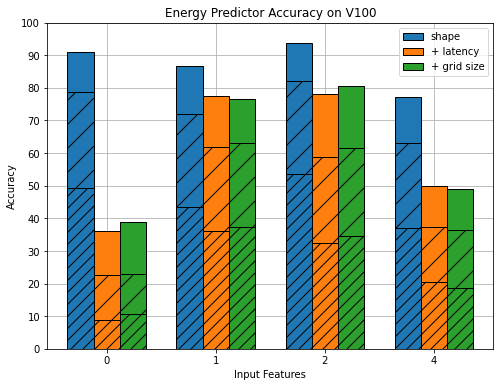

In [9]:
ind = np.arange(len(algorithms))

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

for i, feature_set in enumerate(['shape', '+ latency', '+ grid size']):
# for i, feature_set in enumerate(['shape', '+ grid size', '+ latency']):
    width = 0.24
    ind_shift = ind + (i - 3 // 2) * width
    ax.bar(ind_shift, accs[i, :, 2], hatch='', color=f'C{i}', edgecolor='black', width=width, label=feature_set)
    ax.bar(ind_shift, accs[i, :, 1], hatch='/', color=f'C{i}', edgecolor='black', width=width)
    ax.bar(ind_shift, accs[i, :, 0], hatch='//', color=f'C{i}', edgecolor='black', width=width)

ax.set_xticks(ind, algorithms)
ax.set_yticks(np.arange(11) * 10)
ax.grid()
ax.axis()
ax.set_axisbelow(True)
ax.set_xlabel('Input Features')
ax.set_ylabel('Accuracy')
ax.legend()
ax.set_title('Energy Predictor Accuracy on V100')

Text(0.5, 1.0, 'Energy Predictor RMSE on V100')

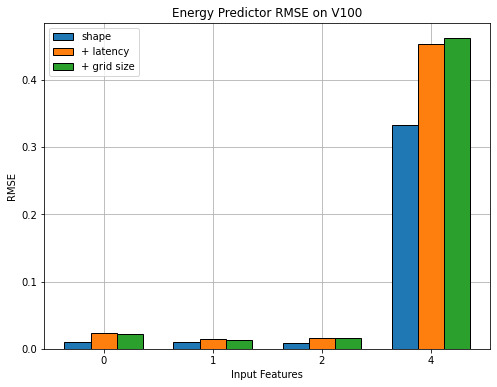

In [10]:
ind = np.arange(len(algorithms))

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

for i, feature_set in enumerate(['shape', '+ latency', '+ grid size']):
    width = 0.24
    ind_shift = ind + (i - 3 // 2) * width
    ax.bar(ind_shift, accs[i, :, 3], hatch='', color=f'C{i}', edgecolor='black', width=width, label=feature_set)

ax.set_xticks(ind, algorithms)
ax.grid()
ax.axis()
ax.set_axisbelow(True)
ax.set_xlabel('Input Features')
ax.set_ylabel('RMSE')
ax.legend()
ax.set_title('Energy Predictor RMSE on V100')